# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for the models
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.svm import SVR


# misc
import warnings
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## Get new clean data

In [2]:
train = pd.read_csv("./train_final.csv")
test = pd.read_csv("./test_final.csv")

train_dummies = pd.read_csv("./train_dummies_final.csv")
test_dummies = pd.read_csv("./test_dummies_final.csv")

train_encoded = pd.read_csv("./train_encoded_final.csv").astype(int)
test_encoded = pd.read_csv("./test_encoded_final.csv").astype(int)

## Target Variable 

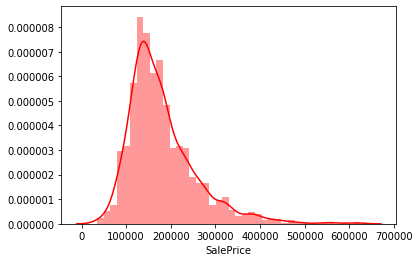

In [3]:
# our target variable is SalePrice
sns.distplot(train['SalePrice'], color='Red');

The target variable is <b>skewed right</b>. We should use a power transformation to make it evenly distributed. Powers < 1 are good for transforming data that is skewed right. This will be done in feature engineering.

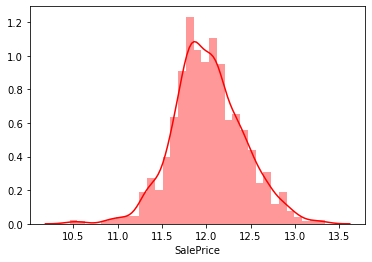

In [4]:
train["SalePrice"] = np.log(train["SalePrice"])
train_dummies["SalePrice"] = np.log(train_dummies["SalePrice"])
train_encoded["SalePrice"] = np.log(train_encoded["SalePrice"])
sns.distplot(train['SalePrice'], color='Red');

## Modeling

In [5]:
# feature scaling
#scaler = StandardScaler()
#train_columns = train.columns
#train = pd.DataFrame(scaler.fit_transform(train), columns = train_columns)

# separate predictors and prediction
y = train_dummies["SalePrice"]
X = train_dummies.drop("SalePrice", axis=1)

ye = train_encoded["SalePrice"]
Xe = train_encoded.drop("SalePrice", axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size = .20, random_state = 0)

# df with each score to make a comparison plot later
d = {'Model': [], 'Score': []}
model_scores_df = pd.DataFrame(data=d)

##### Multiple Linear Regression

In [6]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R^2 for train_split set: %f" %lm.score(X_train, y_train))
print("R^2 for test_split  set: %f" %lm.score(X_test, y_test))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lm.predict(X_test), y_test)))

scores = cross_val_score(lm, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

loo_scores = cross_val_score(lm, X_train, y_train, scoring="neg_mean_squared_error", cv=LeaveOneOut())
print("LOO CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

R^2 for train_split set: 0.932744
R^2 for test_split  set: 0.914361
RMSE for test_split  set: 0.113773
CV RMSE for test_split  set: 0.128056
LOO CV RMSE for test_split  set: 0.128056


##### Ridge

In [7]:
print('-'*15, 'Alpha = 1', '-'*15)
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge.score(X_test, y_test)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(ridge.predict(X_test), y_test)))
scores = cross_val_score(ridge, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())
loo_scores = cross_val_score(ridge, X_train, y_train, scoring="neg_mean_squared_error", cv=LeaveOneOut())
print("LOO CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())


print()
print('-'*15, 'Alpha = 10', '-'*15)

ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge10.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge10.score(X_test, y_test)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(ridge10.predict(X_test), y_test)))
scores = cross_val_score(ridge10, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

print()
print('-'*15, 'Alpha = 0.1', '-'*15)

ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge01.score(X_test, y_test)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(ridge01.predict(X_test), y_test)))
scores = cross_val_score(ridge01, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())


--------------- Alpha = 1 ---------------
Training set score: 0.93088
Test set score: 0.92027
RMSE for test_split  set: 0.109775
CV RMSE for test_split  set: 0.124239
LOO CV RMSE for test_split  set: 0.124239

--------------- Alpha = 10 ---------------
Training set score: 0.92371
Test set score: 0.92030
RMSE for test_split  set: 0.109759
CV RMSE for test_split  set: 0.124204

--------------- Alpha = 0.1 ---------------
Training set score: 0.93259
Test set score: 0.91793
RMSE for test_split  set: 0.111373
CV RMSE for test_split  set: 0.126709


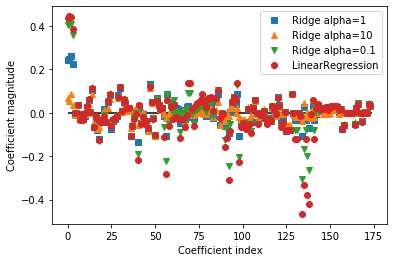

In [8]:
plt.plot(ridge.coef_, 's', label="Ridge alpha=1") 
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10") 
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(lm.coef_, 'o', label="LinearRegression") 
plt.xlabel("Coefficient index") 
plt.ylabel("Coefficient magnitude") 
plt.hlines(0, 0, len(lm.coef_)) 
plt.legend();

##### Lasso

In [9]:
print('-'*15, 'Alpha = 1', '-'*15)

lasso = Lasso(max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lasso.predict(X_test), y_test)))
scores = cross_val_score(lasso, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

print()
print('-'*15, 'Alpha = 0.01', '-'*15)

lasso01 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso01.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso01.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso01.coef_ != 0)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lasso01.predict(X_test), y_test)))
scores = cross_val_score(lasso01, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

print()
print('-'*15, 'Alpha = 0.001', '-'*15)

lasso001 = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lasso001.predict(X_test), y_test)))
scores = cross_val_score(lasso001, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

print()
print('-'*15, 'Alpha = 0.0001', '-'*15)

lasso0001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso0001.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso0001.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso0001.coef_ != 0)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lasso0001.predict(X_test), y_test)))
scores = cross_val_score(lasso0001, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

--------------- Alpha = 1 ---------------
Training set score: 0.69
Test set score: 0.70
Number of features used: 6
RMSE for test_split  set: 0.212573
CV RMSE for test_split  set: 0.223062

--------------- Alpha = 0.01 ---------------
Training set score: 0.83
Test set score: 0.84
Number of features used: 23
RMSE for test_split  set: 0.157592
CV RMSE for test_split  set: 0.168512

--------------- Alpha = 0.001 ---------------
Training set score: 0.91
Test set score: 0.92
Number of features used: 80
RMSE for test_split  set: 0.111277
CV RMSE for test_split  set: 0.129161

--------------- Alpha = 0.0001 ---------------
Training set score: 0.93
Test set score: 0.92
Number of features used: 146
RMSE for test_split  set: 0.108485
CV RMSE for test_split  set: 0.123601


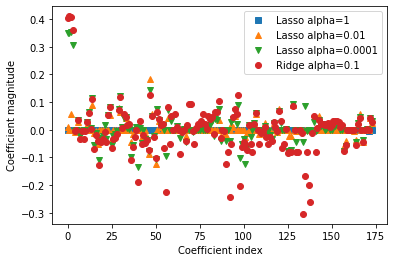

In [10]:
plt.plot(lasso.coef_, 's', label="Lasso alpha=1") 
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01") 
plt.plot(lasso0001.coef_, 'v', label="Lasso alpha=0.0001")
plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1") 
plt.legend()
plt.xlabel("Coefficient index") 
plt.ylabel("Coefficient magnitude");

##### ElasticNet

In [11]:
print('-'*15, 'normalize=False', '-'*15)

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=False)
elasticnet.fit(X, y)
print(r'The R^2 !normalized is %.2f' %(elasticnet.score(X, y)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(elasticnet.predict(X_test), y_test)))
scores = cross_val_score(elasticnet, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

print()
print('-'*15, 'normalize=True', '-'*15)

elasticnetNorm = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=True)
elasticnetNorm.fit(X, y)
print(r'The R^2 normalized is %.2f' %(elasticnetNorm.score(X, y)))
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(elasticnetNorm.predict(X_test), y_test)))
scores = cross_val_score(elasticnetNorm, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

--------------- normalize=False ---------------
The R^2 !normalized is 0.72
RMSE for test_split  set: 0.204100
CV RMSE for test_split  set: 0.212357

--------------- normalize=True ---------------
The R^2 normalized is 0.00
RMSE for test_split  set: 0.389413
CV RMSE for test_split  set: 0.395819


#### Gradient Boosting Regressor

RMSE for test_split  set: 0.111286
CV RMSE for test_split  set: 0.131357


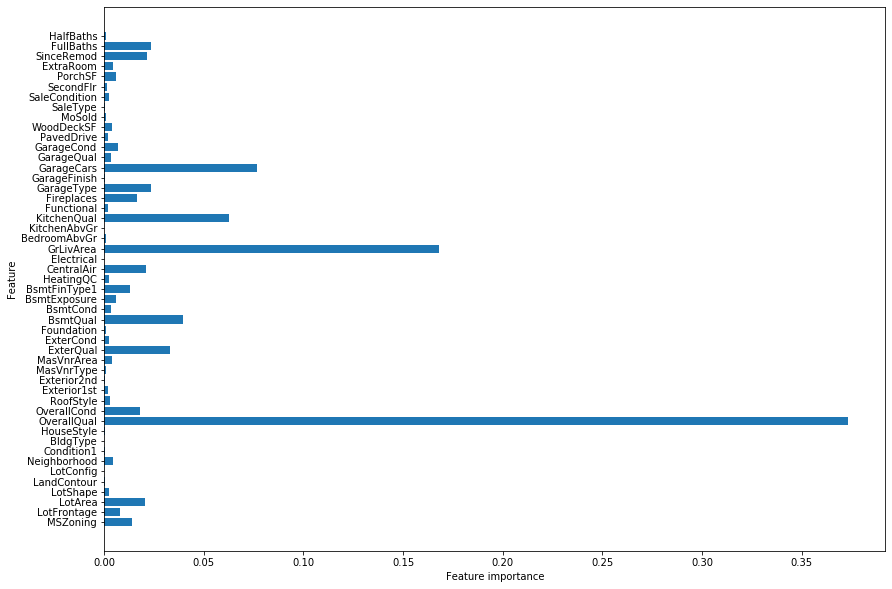

In [12]:
gbm = GradientBoostingRegressor().fit(Xe_train, ye_train)
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(gbm.predict(Xe_test), ye_test)))
scores = cross_val_score(gbm, Xe_train, ye_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

plt.figure(figsize=(14,10))
n_features = Xe_train.shape[1]
plt.barh(range(n_features), gbm.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), Xe_train.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature");

##### LightGBM

In [13]:
lightgbm = LGBMRegressor(objective='regression').fit(X_train, y_train)
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(lightgbm.predict(X_test), y_test)))
scores = cross_val_score(lightgbm, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

RMSE for test_split  set: 0.111043
CV RMSE for test_split  set: 0.139503


#### XGBoost

In [14]:
xgboost = XGBRegressor().fit(X_train, y_train)
print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(xgboost.predict(X_test), y_test)))
scores = cross_val_score(xgboost, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print("CV RMSE for test_split  set: %f" %np.sqrt(-scores).mean())

# insert into model_scores_df
#model_scores_df = model_scores_df.append({'Model': 'XGBoost', 'Score': score.mean()}, ignore_index=True)

RMSE for test_split  set: 0.130974
CV RMSE for test_split  set: 0.146433


#### Random Forest Regressor

RMSE for test_split  set: 0.133575


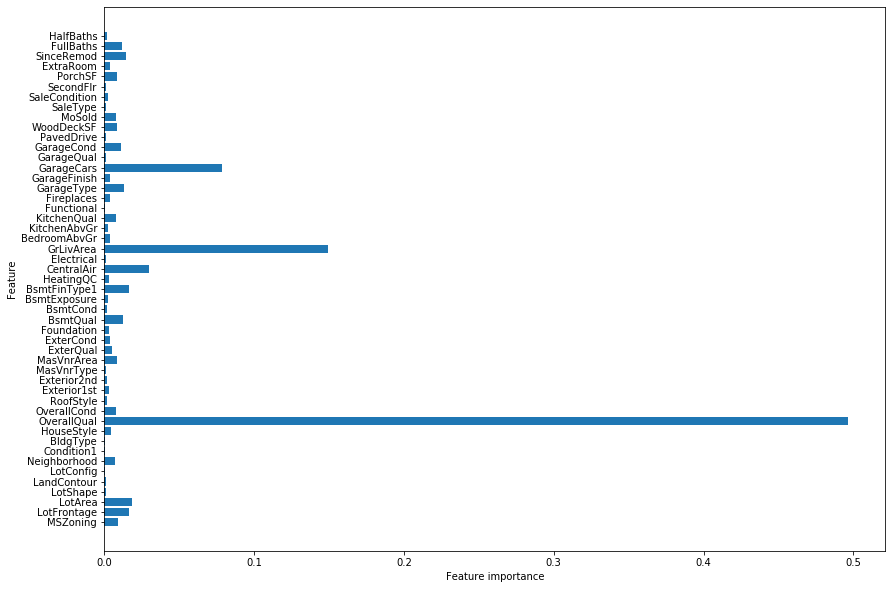

In [15]:
forest = RandomForestRegressor() 
forest.fit(Xe_train, ye_train)

print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(forest.predict(Xe_test), ye_test)))

plt.figure(figsize=(14,10))
n_features = Xe_train.shape[1]
plt.barh(range(n_features), forest.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), Xe_train.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature");

#### Random Forest Grid Search

In [16]:
#grid_para_tree = [{'n_estimators': range(200,300,10), 'max_features': np.log2(Xe_train.shape[1])}]

#forest_reg = RandomForestRegressor()
#grid_search = GridSearchCV(forest_reg, grid_para_tree, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(Xe_train, ye_train)

#grid_search.best_params_, grid_search.best_estimator_

In [17]:
#cvres = grid_search.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
#    print(np.sqrt(-mean_score), params)

#### Decision Tree Regressor

RMSE for test_split  set: 0.196221


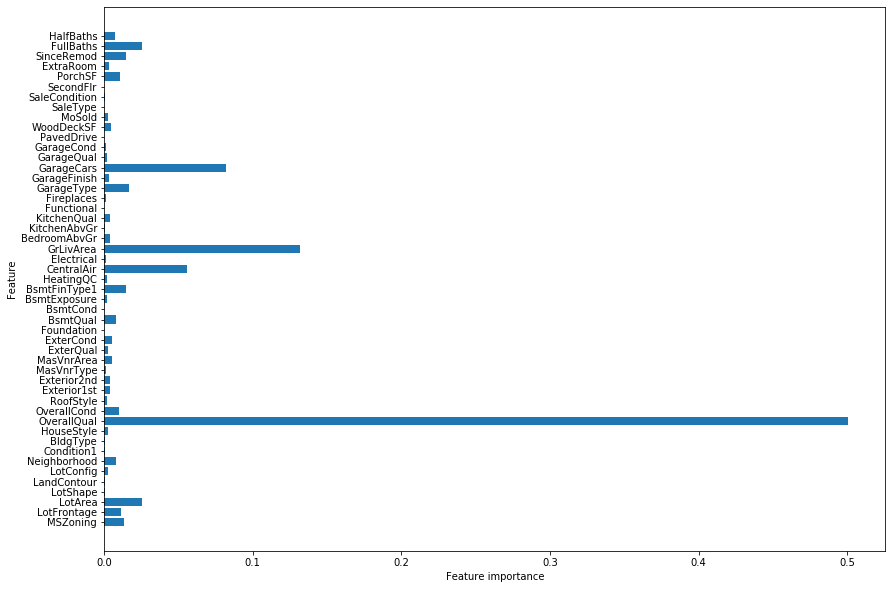

In [18]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(Xe_train, ye_train)

print("RMSE for test_split  set: %f" %np.sqrt(mean_squared_error(tree_reg.predict(Xe_test), ye_test)))

#print("Feature importances:\n{}".format(tree_reg.feature_importances_))
plt.figure(figsize=(14,10))
n_features = Xe_train.shape[1]
plt.barh(range(n_features), tree_reg.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), Xe_train.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature");  

#### Support Vector Machine (Regressor)

In [19]:
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVR(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
svm = SVR(**best_parameters)
svm.fit(X_test, y_test)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score)) 
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.02
Best parameters:  {'C': 1, 'gamma': 0.001}
Test set score with best parameters: 0.94


#### Comparison

In [20]:
# Plot the predictions for each model
#fig = plt.figure(figsize=(24, 12))
#ax = sns.pointplot(x='Model', y='Score', data=model_scores_df)

#plt.ylabel('RMSE', size=20, labelpad=12.5)
#plt.xlabel('Model', size=20, labelpad=12.5)
#plt.tick_params(axis='x', labelsize=13.5)
#plt.tick_params(axis='y', labelsize=12.5)

#plt.show()

## Feature Importance

#### Permutation

Breiman and Cutler also described permutation importance, which measures the importance of a feature as follows. Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. The permutation mechanism is much more computationally expensive than the mean decrease in impurity mechanism, but the results are more reliable. The permutation importance strategy does not require retraining the model after permuting each column; we just have to re-run the perturbed test samples through the already-trained model.

In [27]:
def permutation_importances(rf, Xe_train, ye_train, metric):
    baseline = metric(rf, Xe_train, ye_train)
    imp = []
    for col in Xe_train.columns:
        save = Xe_train[col].copy()
        Xe_train[col] = np.random.permutation(Xe_train[col])
        m = metric(rf, Xe_train, ye_train)
        Xe_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

def _get_unsampled_indices(tree, n_samples):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    if LooseVersion(sklearn.__version__) >= LooseVersion("0.22"):
        # Version 0.22 or newer uses 3 arguments.
        from sklearn.ensemble.forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    else:
        # Version 0.21 or older uses only two arguments.
        return _generate_unsampled_indices(tree.random_state, n_samples)

In [29]:
rf = RandomForestRegressor()
rf.fit(Xe_train, ye_train) # rf must be pre-trained
imp = permutation_importances(rf, Xe_train, ye_train, oob_regression_r2_score)

NameError: name 'LooseVersion' is not defined

In [30]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

## Storytelling

Cross Validation: When performing train_test_split of the data, we can get “lucky” when randomly splitting the data. For example, the test set can only contain “easy” examples, and our test set accuracy will be unrealistically high. On the other hand, if we are “unlucky,” we might have randomly put all the examples that are hard to classify in the test set and consequently obtain an unrealistically low score. However, when using cross-validation, each example is in one of the folds, and each fold is the test set once. Another benefit is that we use our data more effectively. When using five-fold cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the model. When using 10-fold cross-validation, we can use nine-tenths of the data (90%) to fit the model. More data will usually result in more accurate models.

Grid Search: Any choices made based on the test set accuracy “leak” information from the test set into the model. 

Trees: If a feature has a low feature_importance, it doesn’t mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information. Essentially, random forests share all of the benefits of decision trees, while making up for some of their deficiencies. One reason to still use decision trees is if you need a compact representation of the decision-making process. It is basically impossible to interpret tens or hundreds of trees in detail, and trees in random forests tend to be deeper than decision trees (because of the use of feature subsets). Therefore, if you need to summarize the prediction making in a visual way to nonexperts, a single decision tree might be a better choice.

Keeping the end goal in mind: When selecting a metric, we should always have the end goal of the machine learning application in mind. In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decision making process. The consequences of choosing a particular algorithm for a machine learning application is important.